#### Import Modules

In [1]:
import tensorflow as tf 
import os
from tensorflow.examples.tutorials.mnist import input_data
print("All Modules Loaded ----------->. ")

All Modules Loaded ----------->. 


In [2]:
class Siamese(object):
    
    def __init__(self):
        
        #----set up place holders for inputs and labels for the siamese network--- # two input placeholders for Siamese network
        self.tf_inputA = tf.placeholder(tf.float32, [None, 784], name = 'inputA')
        self.tf_inputB = tf.placeholder(tf.float32, [None, 784], name = 'inputB')
        
        # labels for the image pair        # 1: similar, 0: dissimilar
        self.tf_Y = tf.placeholder(tf.float32, [None,], name = 'Y')

        # outputs, loss function and training optimizer
        self.outputA, self.outputB = self.siameseNetwork() 
        self.loss = self.contastiveLoss()
        self.optimizer = self.optimizer_initializer()

        # Initialize tensorflow session
        self.sess = tf.Session() 
        self.sess.run(tf.global_variables_initializer())
        
    def layer(self, tf_input, num_hidden_units, variable_name):
        
        # tf_input: batch_size x n_features
        # num_hidden_units: number of hidden units
        tf_weight_initializer = tf.random_normal_initializer(mean = 0, stddev = 0.01) 
        num_features = tf_input.get_shape()[1]
        
        W = tf.get_variable(
            name = variable_name + '_W',
            dtype = tf.float32,
            shape = [num_features, num_hidden_units],
            initializer = tf_weight_initializer
            )
        
        b = tf.get_variable(
            name = variable_name + '_b',
            dtype = tf.float32,
            shape = [num_hidden_units]
            )
        
        out = tf.add(tf.matmul(tf_input, W), b) 
        return out
        
    def network(self, tf_input):
        fc1 = self.layer(tf_input = tf_input, num_hidden_units = 1024, variable_name = 'fc1')
        ac1 = tf.nn.relu(fc1)
        
        fc2 = self.layer(tf_input = ac1, num_hidden_units = 1024, variable_name = 'fc2')
        ac2 = tf.nn.relu(fc2)
        
        fc3 = self.layer(tf_input = ac2, num_hidden_units = 2, variable_name = 'fc3')
        return fc3
    
    def siameseNetwork(self):
        # Initialze neural network
        with tf.variable_scope("siamese", reuse=tf.AUTO_REUSE) as scope:
            outputA = self.network(self.tf_inputA)
            
            # share weights
            scope.reuse_variables()
            outputB = self.network(self.tf_inputB)
        return outputA, outputB
        
    def contastiveLoss(self, margin=5.0):
        with tf.variable_scope("siamese") as scope:
            labels = self.tf_Y
            
            # Euclidean distance squared
            dist = tf.pow(tf.subtract(self.outputA, self.outputB), 2, name = 'Dw') 
            Dw = tf.reduce_sum(dist, 1)
            
            # add 1e-6 to increase the stability of calculating the gradients
            Dw2 = tf.sqrt(Dw + 1e-6, name = 'Dw2')
            
            # Loss function
            lossSimilar = tf.multiply(labels, tf.pow(Dw2,2), name = 'constrastiveLoss_1')
            lossDissimilar = tf.multiply(tf.subtract(1.0, labels), tf.pow(tf.maximum(tf.subtract(margin, Dw2), 0), 2), name = 'constrastiveLoss_2')
            
            loss = tf.reduce_mean(tf.add(lossSimilar, lossDissimilar), name ='constrastiveLoss')
            return loss
            
            
    def optimizer_initializer(self):
        LEARNING_RATE = 0.01
        RAND_SEED = 0 # random seed
        tf.set_random_seed(RAND_SEED)
        optimizer =tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(self.loss) 
        return optimizer
    
    def trainSiamese(self, mnist,numIterations, batchSize=100):
        for i in range(numIterations):
            input1, y1 = mnist.train.next_batch(batchSize)
            input2, y2 = mnist.train.next_batch(batchSize)
            label = (y1 == y2).astype('float')
            _, trainingLoss = self.sess.run([self.optimizer, self.loss],
                                            feed_dict = {self.tf_inputA: input1,
                                                         self.tf_inputB: input2,
                                                         self.tf_Y: label})
            if i % 50 == 0:
                print('iteration %d: train loss %.3f' % (i, trainingLoss))
    
    def test_model(self, input):
        # Test the trained model
        output = self.sess.run(self.outputA, feed_dict = {self.tf_inputA: input})
        return output

In [3]:

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
def visualize(embed, labels):
    labelset = set(labels.tolist())
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    for label in labelset:
        indices = np.where(labels == label)
        ax.scatter(embed[indices,0], embed[indices,1], label = label, s = 20)
        ax.legend()
    #fig.savefig('embed.jpeg', format='jpeg', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
iteration 0: train loss 22.188
iteration 50: train loss 5.843
iteration 100: train loss 6.001
iteration 150: train loss 3.552
iteration 200: train loss 3.072
iteration 250: train loss 1.614
iteration 300: train loss 2.326
iteration 350: train

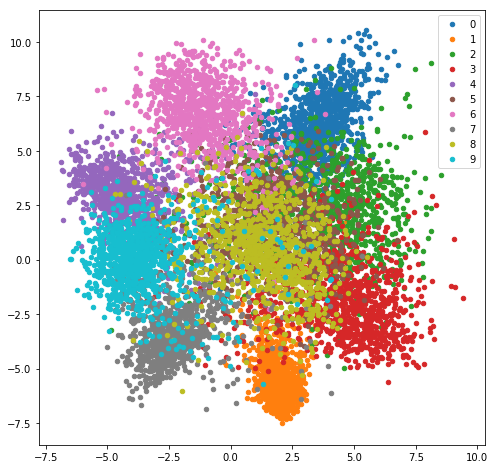

In [5]:
def main():
    mnist = input_data.read_data_sets('MNIST_data', one_hot = False)
    mnist_test_labels = mnist.test.labels
    siamese = Siamese()
    siamese.trainSiamese(mnist,1000,100)
    embed = siamese.test_model(input = mnist.test.images)
    embed = embed.reshape([-1, 2])
    visualize(embed, mnist_test_labels)

    
if __name__ == '__main__':
    main()
